# Predict shapes

In [1]:
import sys
sys.path.insert(0, "..")
import os
from glob import glob
import natsort
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from pathlib import Path
import shutil
import torch
import torch.nn as nn

from sklearn.metrics import confusion_matrix
from PIL import Image

In [2]:
from dataloader import load_images, load_masks, mask2rgb, rgb2mask, get_image_names
from lib import compose_image, plot_patches, input_filled_mirroring
from model import UNet, make_dataloaders, IoU, UnetFracture

In [3]:
PATH_PARAMETERS = '../params.json'

with open(PATH_PARAMETERS) as f:
    params = json.load(f)

model_params = params['shape_segmentation']['patches_s96']

In [10]:
mode = 'train'
file_names = get_image_names(mode=mode)
images = load_images(file_names,mode=mode)
masks = load_masks(file_names,mode=mode)

(-0.5, 255.5, 511.5, -0.5)

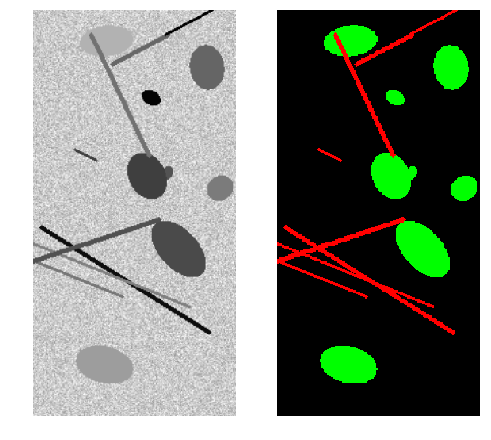

In [11]:
ix = 1

fig, ax = plt.subplots(1,2, figsize=(8,10))
ax[0].imshow(images[ix], cmap='gray')
ax[0].axis('off')
ax[1].imshow(masks[ix])
ax[1].axis('off')

In [12]:
model = UnetFracture(model_params)
model.initialize()

In [13]:
ix = 1
image = images[ix]
mask_rgb = masks[ix]
mask_labels = rgb2mask(mask_rgb).astype(int)

mask_prob = model.predict_proba(image)
mask_predict = model.predict_image(image)
mask_predict_rgb = mask2rgb(mask_predict)
class_iou, mean_iou = IoU(mask_labels, mask_predict, model_params['n_classes'])

Class IoU: 0.999 0.983 0.991   |  Mean IoU: 0.991


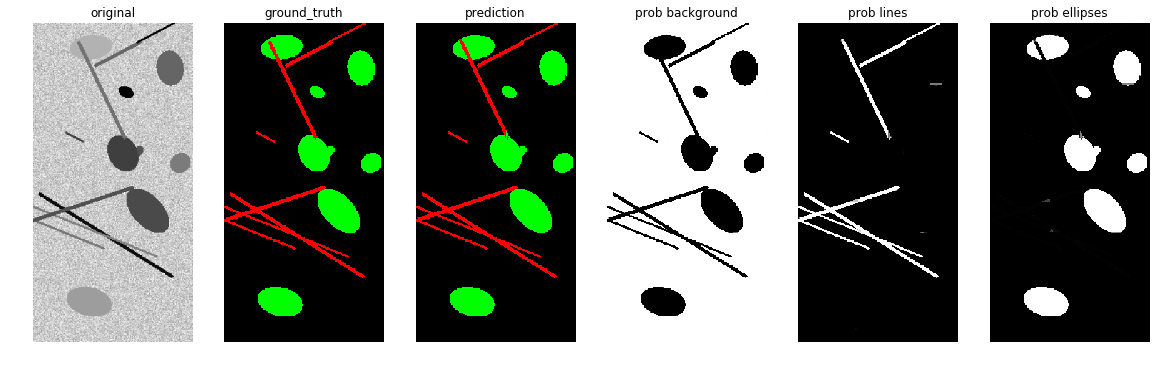

In [14]:
fig, ax = plt.subplots(1,6,figsize=(20,20))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('original')
ax[0].axis('off')
ax[1].imshow(mask_rgb, cmap='gray')
ax[1].set_title('ground_truth')
ax[1].axis('off')
ax[2].imshow(mask_predict_rgb)
ax[2].set_title('prediction')
ax[2].axis('off')
ax[3].imshow(mask_prob[:,:,0], cmap='gray')
ax[3].set_title('prob background')
ax[3].axis('off')
ax[4].imshow(mask_prob[:,:,1], cmap='gray')
ax[4].set_title('prob lines')
ax[4].axis('off')
ax[5].imshow(mask_prob[:,:,2], cmap='gray')
ax[5].set_title('prob ellipses')
ax[5].axis('off')

print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')

In [15]:
m_ious = []
cf_ious = []

for i, (image,mask_rgb) in enumerate(zip(images,masks)):
    
    mask_labels = rgb2mask(mask_rgb).astype(int)
    mask_prob = model.predict_proba(image)
    mask_predict = model.predict_image(image)
    mask_predict_rgb = mask2rgb(mask_predict)
    
    class_iou, mean_iou = IoU(mask_labels, mask_predict, model_params['n_classes'])
    
    m_ious.append(mean_iou)
    
    
    print(f'{i}: Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')
#     plot_results(img, img_bin, mask_rgb, img_prob, sines) 

0: Class IoU: 1.000 0.994 0.999   |  Mean IoU: 0.998
1: Class IoU: 0.999 0.983 0.991   |  Mean IoU: 0.991
2: Class IoU: 1.000 0.960 0.980   |  Mean IoU: 0.980
3: Class IoU: 0.999 0.959 0.981   |  Mean IoU: 0.980
4: Class IoU: 0.999 0.967 0.992   |  Mean IoU: 0.986
5: Class IoU: 1.000 0.997 0.997   |  Mean IoU: 0.998
6: Class IoU: 1.000 0.998 0.986   |  Mean IoU: 0.994
7: Class IoU: 1.000 0.992 0.997   |  Mean IoU: 0.996
8: Class IoU: 1.000 0.993 0.989   |  Mean IoU: 0.994
9: Class IoU: 0.999 0.931 0.972   |  Mean IoU: 0.968
10: Class IoU: 0.999 0.944 0.984   |  Mean IoU: 0.976
11: Class IoU: 0.998 0.918 0.974   |  Mean IoU: 0.964
12: Class IoU: 0.999 0.966 0.995   |  Mean IoU: 0.987
13: Class IoU: 1.000 0.938 0.991   |  Mean IoU: 0.976
14: Class IoU: 1.000 0.991 0.989   |  Mean IoU: 0.993
15: Class IoU: 1.000 0.988 0.996   |  Mean IoU: 0.995
16: Class IoU: 1.000 0.768 0.942   |  Mean IoU: 0.903
17: Class IoU: 1.000 0.998 0.993   |  Mean IoU: 0.997
18: Class IoU: 0.999 0.966 0.978   |  

In [16]:
print(np.mean(m_ious))

0.9836849862622269
